In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatches
from PIL import Image

import tensorflow as tf
from tensorflow import keras
import keras.layers as layers
import sklearn.metrics as metrics

tf.compat.v1.enable_eager_execution()

In [2]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
DATASET_FOLDER = "../input/mnist-for-object-detection/mnist_detection"

In [3]:
def get_labels(set: str) -> []:
    folder = f"{DATASET_FOLDER}/{set}/labels/"
    return [pd.read_csv(folder + name) for name in sorted(os.listdir(folder))]
        
train_labels = get_labels("train")
test_labels = get_labels("test")

In [4]:
# print(train_labels[1])

In [5]:
train_images_name = sorted(os.listdir(f"{DATASET_FOLDER}/train/images"))
test_images_name = sorted(os.listdir(f"{DATASET_FOLDER}/test/images"))

In [6]:
raw_train_loader = tf.data.Dataset.from_tensor_slices((
    train_images_name,
    [label.label for label in train_labels],
    [[label.xmin, label.ymin, label.xmax, label.ymax] for label in train_labels],
))

raw_test_loader = tf.data.Dataset.from_tensor_slices((
    test_images_name,
    [label.label for label in test_labels],
    [[label.xmin, label.ymin, label.xmax, label.ymax] for label in test_labels],
))

2022-11-12 12:47:10.320988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 12:47:10.455696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 12:47:10.456476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 12:47:10.458811: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
# for element in train_loader.as_numpy_iterator():
#     print(element)

In [8]:

def preprocess_train(image_name, label, bbox):
    image = tf.io.read_file(f"{DATASET_FOLDER}/train/images/" + image_name)
    image = tf.image.decode_png(image, channels=1)
#     image.set_shape((100,100,1))
#     print(label, bbox)
    bbox = bbox / 300
    bbox = tf.reshape(bbox, (4,))
    print(bbox)
    return image, {'label': label, 'bbox': bbox}

def preprocess_test(image_name, label, bbox):
    image = tf.io.read_file(f"{DATASET_FOLDER}/test/images/" + image_name)
    image = tf.image.decode_png(image, channels=1)
    bbox = bbox / 300
    bbox = tf.reshape(bbox, (4,))
    return image, {'label': label, 'bbox': bbox}

In [63]:
train_loader = (
    raw_train_loader
    .map(preprocess_train, num_parallel_calls=AUTO)
#     .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_loader = (
    raw_test_loader
    .map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


Tensor("Reshape:0", shape=(4,), dtype=float64)


In [64]:
train_loader

<PrefetchDataset shapes: ((None, None, None, 1), {label: (None, 1), bbox: (None, 4)}), types: (tf.uint8, {label: tf.int32, bbox: tf.float64})>

In [65]:
def get_model():
    inputs = layers.Input(shape=(300,300,1))
    
    cnn = layers.Conv2D(16, (3,3), activation='relu')(inputs)
    cnn = layers.MaxPooling2D((3,3))(cnn)
    cnn = layers.Conv2D(32, (3,3), activation='relu')(cnn)
    cnn = layers.MaxPooling2D((3,3))(cnn)
    cnn = layers.Conv2D(64, (3,3), activation='relu')(cnn)
    cnn = layers.MaxPooling2D((3,3))(cnn)
    cnn = layers.Conv2D(64, (3,3), activation='relu')(cnn)
    cnn = layers.GlobalAveragePooling2D()(cnn)
    cnn = layers.Flatten()(cnn)
    
    classifier = layers.Dropout(.3)(cnn)
    classifier = layers.Dense(32, activation='relu')(classifier)
    classifier = layers.Dense(10, activation='softmax', name='label')(classifier)
    
    regression = layers.Dense(128, activation='relu')(cnn)
    regression = layers.Dense(32, activation='relu')(regression)
    regression = layers.Dense(4, activation='sigmoid', name='bbox')(regression)
    
    return keras.Model(inputs=[inputs], outputs=[classifier, regression])

In [66]:
model = get_model()
model.compile(
    optimizer='adam',
    loss={'label': 'sparse_categorical_crossentropy', 'bbox': 'mse'},
    metrics=['accuracy']
)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 300, 300, 1) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 298, 298, 16) 160         input_10[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_27 (MaxPooling2D) (None, 99, 99, 16)   0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 97, 97, 32)   4640        max_pooling2d_27[0][0]           
____________________________________________________________________________________________

In [67]:
from IPython.display import clear_output

# model.summary()
print(train_loader)
model.fit(train_loader, epochs=10)

clear_output()

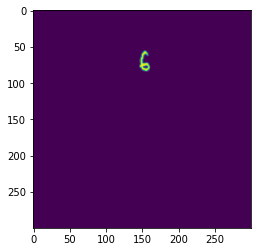

In [68]:
raw_loader = [[img, info] for img, info in test_loader.unbatch()]
data = {'imgs': [], 'labels': [], 'bboxs': []}

for m in raw_loader[:10]:
    data['imgs'].append(m[0])
    plt.imshow(m[0])
    data['labels'].append(m[1]['label'].numpy())
    print(m[1]['label'].numpy())
    data['bboxs'].append(m[1]['bbox'].numpy() * 300)

clear_output()
    
# print(raw_loader[0])

In [69]:
model.evaluate(test_loader)

 7/32 [=====>........................] - ETA: 0s - loss: 0.2799 - label_loss: 0.2683 - bbox_loss: 0.0117 - label_accuracy: 0.9152 - bbox_accuracy: 0.8839

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

16/32 [==============>...............] - ETA: 0s - loss: 0.2760 - label_loss: 0.2637 - bbox_loss: 0.0123 - label_accuracy: 0.9141 - bbox_accuracy: 0.8438

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

25/32 [======================>.......] - ETA: 0s - loss: 0.2973 - label_loss: 0.2858 - bbox_loss: 0.0114 - label_accuracy: 0.9038 - bbox_accuracy: 0.8512

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

32/32 [==============================] - 1s 22ms/step - loss: 0.2754 - label_loss: 0.2641 - bbox_loss: 0.0112 - label_accuracy: 0.9110 - bbox_accuracy: 0.8490


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

[0.27539554238319397,
 0.2641485035419464,
 0.011247063986957073,
 0.9110000133514404,
 0.8489999771118164]

In [70]:
y_pred = model.predict(test_loader)
y_pred_labels = [np.argmax(v) for v in y_pred[0]]
y_pred_bboxs = [v * 300 for v in y_pred[1]]

clear_output()

# print(metrics.classification_report(y_pred_classes, ds_labels))

In [71]:
# y_pred_bboxs

[8]
134.0 176.0 192.0 243.00000000000003


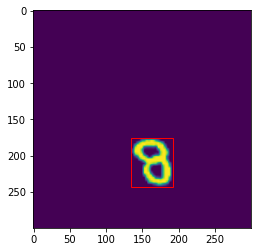

In [72]:
# Shows img and true labels

num = 2

im = data['imgs'][num]
plt.imshow(im)
ax = plt.gca()

    
x = data['bboxs'][num][0]
y = data['bboxs'][num][1]
width = data['bboxs'][num][2] - data['bboxs'][num][0]
height = data['bboxs'][num][3] - data['bboxs'][num][1]

print(data['labels'][num])
print(x, y, x+width, y+height)

rect = pltpatches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

number: 3


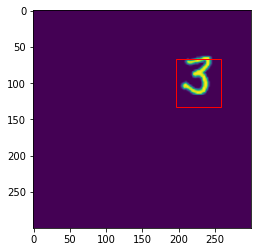

In [86]:
# Shows img and predicted labels

num = 1

im = data['imgs'][num]
plt.imshow(im)
ax = plt.gca()

    
x = y_pred_bboxs[num][0]
y = y_pred_bboxs[num][1]
width = y_pred_bboxs[num][2] - y_pred_bboxs[num][0]
height = y_pred_bboxs[num][3] - y_pred_bboxs[num][1]

print("number:", y_pred_labels[num])
# print(x, y, x+width, y+height)

rect = pltpatches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)